<a href="https://colab.research.google.com/github/Bashar-1216/500-AI-Agents-Projects/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 4

In this assignment, you will perform semantic segmentation using a fully convolutional CNN model and visualize the results on sample images. You need to evaluate the model and print the confusion matrix to assess class-wise performance.

## 1. Loading the dataset

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2025-11-22 13:58:57--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2025-11-22 13:58:57--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/pets/images.tar.gz [following]
--2025-11-22 13:58:58--  https://thor.robots.ox.ac.uk/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [app

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

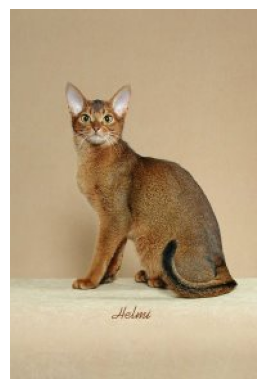

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[12]))

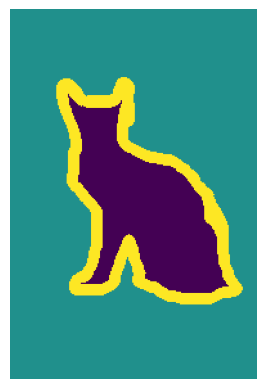

In [ ]:
def display_target(target_array):
    plt.axis("off")
    plt.imshow(target_array[:, :, 0])

img = img_to_array(load_img(target_paths[12], color_mode="grayscale"))
display_target(img)

## 2. Prepare the dataset for training the model (20 Points)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
IMG_SIZE = 224  # Resize images to 200x200
BATCH_SIZE = 32
NUM_CLASSES = 3  # Background, Pet, Outline

# Split data into train and validation sets
val_samples = int(len(input_img_paths) * 0.2)
random_indices = np.random.permutation(len(input_img_paths))
train_indices = random_indices[val_samples:]
val_indices = random_indices[:val_samples]

train_input_img_paths = [input_img_paths[i] for i in train_indices]
train_target_img_paths = [target_paths[i] for i in train_indices]
val_input_img_paths = [input_img_paths[i] for i in val_indices]
val_target_img_paths = [target_paths[i] for i in val_indices]

print(f"Total samples: {len(input_img_paths)}")
print(f"Training samples: {len(train_input_img_paths)}")
print(f"Validation samples: {len(val_input_img_paths)}")

# Data generator class
class OxfordPetDataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")

        for j, (input_path, target_path) in enumerate(zip(batch_input_img_paths, batch_target_img_paths)):
            img = load_img(input_path, target_size=self.img_size)
            x[j] = img_to_array(img) / 255.0  # Normalize to [0, 1]

            mask = load_img(target_path, target_size=self.img_size, color_mode="grayscale")
            mask_array = img_to_array(mask)
            # Convert mask values to class indices
            # Original mask values: 1=background, 2=pet, 3=outline
            # Target class indices: 0=background, 1=pet, 2=outline
            # Handle both normalized (0-1) and original (1-3) values
            mask_array = mask_array.astype(np.float32)
            # If values are normalized (0-1 range), denormalize first
            if mask_array.max() <= 1.0:
                mask_array = mask_array * 255.0
            # Convert to class indices: 1->0, 2->1, 3->2
            mask_array = np.clip(mask_array, 1, 3)
            mask_array = mask_array - 1  # Convert 1,2,3 to 0,1,2
            y[j] = mask_array.astype(np.uint8)

        return x, y

# Create dataset generators
train_gen = OxfordPetDataset(BATCH_SIZE, (IMG_SIZE, IMG_SIZE), train_input_img_paths, train_target_img_paths)
val_gen = OxfordPetDataset(BATCH_SIZE, (IMG_SIZE, IMG_SIZE), val_input_img_paths, val_target_img_paths)


Total samples: 7390
Training samples: 5912
Validation samples: 1478


## 3. Build CNN model (30 Points)

In [ ]:
def get_model(img_size, num_classes):
    """Build a Fully Convolutional Network (FCN) for semantic segmentation."""
    inputs = keras.Input(shape=img_size + (3,))

    # Encoder (Downsampling path)
    # Block 1
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Store for skip connection

    # Block 2
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Block 3
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    block_3_output = layers.Activation("relu")(x)

    # Block 4
    x = layers.Conv2D(256, 3, strides=2, padding="same")(block_3_output)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Decoder (Upsampling path)
    # Block 5
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Concatenate()([x, block_3_output])  # Skip connection

    # Block 6
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Block 7
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Block 8 (Final upsampling)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Output layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

# Build the model
model = get_model((IMG_SIZE, IMG_SIZE), NUM_CLASSES)
model.summary()

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 112, 112,  │        896 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 56, 56,    │     18,496 │ activation_21[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 28, 28,    │     73,856 │ activation_22[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 14, 14,    │    295,168 │ activation_23[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      1,024 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 28, 28,    │    295,040 │ activation_24[0]… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 28, 28,    │          0 │ activation_25[0]

 Total params: 862,499 (3.29 MB)

 Trainable params: 861,027 (3.28 MB)

 Non-trainable params: 1,472 (5.75 KB)

## 4. a- Train the model (10 Points)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min"),
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
]

# Train the model
EPOCHS = 30

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5764 - loss: 0.8944

184/184 ━━━━━━━━━━━━━━━━━━━━ 54s 191ms/step - accuracy: 0.5768 - loss: 0.8937 - val_accuracy: 0.5819 - val_loss: 0.8860 - learning_rate: 0.0010
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7402 - loss: 0.6205

184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 184ms/step - accuracy: 0.7402 - loss: 0.6204 - val_accuracy: 0.6864 - val_loss: 0.7460 - learning_rate: 0.0010
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7694 - loss: 0.5592

184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 184ms/step - accuracy: 0.7694 - loss: 0.5592 - val_accuracy: 0.7222 - val_loss: 0.6745 - learning_rate: 0.0010
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7844 - loss: 0.5255

184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 181ms/step - accuracy: 0.7844 - loss: 0.5255 - val_accuracy: 0.7662 - val_loss: 0.5587 - learning_rate: 0.0010
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 184ms/step - accuracy: 0.7966 - loss: 0.5024 - val_accuracy: 0.7421 - val_loss: 0.5957 - learning_rate: 0.0010
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8081 - loss: 0.4739

184/184 ━━━━━━━━━━━━━━━━━━━━ 35s 187ms/step - accuracy: 0.8081 - loss: 0.4739 - val_accuracy: 0.7813 - val_loss: 0.5293 - learning_rate: 0.0010
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8163 - loss: 0.4552

184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 181ms/step - accuracy: 0.8163 - loss: 0.4552 - val_accuracy: 0.7931 - val_loss: 0.5032 - learning_rate: 0.0010
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8209 - loss: 0.4436

184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 183ms/step - accuracy: 0.8209 - loss: 0.4436 - val_accuracy: 0.8063 - val_loss: 0.4796 - learning_rate: 0.0010
Epoch 9/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8280 - loss: 0.4292

184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 183ms/step - accuracy: 0.8280 - loss: 0.4292 - val_accuracy: 0.8161 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 10/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 179ms/step - accuracy: 0.8336 - loss: 0.4161 - val_accuracy: 0.8179 - val_loss: 0.4601 - learning_rate: 0.0010
Epoch 11/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 186ms/step - accuracy: 0.8400 - loss: 0.4007 - val_accuracy: 0.7950 - val_loss: 0.5046 - learning_rate: 0.0010
Epoch 12/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8435 - loss: 0.3929

184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 186ms/step - accuracy: 0.8435 - loss: 0.3929 - val_accuracy: 0.8242 - val_loss: 0.4403 - learning_rate: 0.0010
Epoch 13/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 180ms/step - accuracy: 0.8488 - loss: 0.3794 - val_accuracy: 0.8203 - val_loss: 0.4560 - learning_rate: 0.0010
Epoch 14/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 182ms/step - accuracy: 0.8544 - loss: 0.3661 - val_accuracy: 0.8251 - val_loss: 0.4471 - learning_rate: 0.0010
Epoch 15/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8608 - loss: 0.3505

184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 184ms/step - accuracy: 0.8608 - loss: 0.3506 - val_accuracy: 0.8256 - val_loss: 0.4395 - learning_rate: 0.0010
Epoch 16/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 180ms/step - accuracy: 0.8621 - loss: 0.3466 - val_accuracy: 0.8254 - val_loss: 0.4527 - learning_rate: 0.0010
Epoch 17/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 184ms/step - accuracy: 0.8652 - loss: 0.3393 - val_accuracy: 0.8263 - val_loss: 0.4545 - learning_rate: 0.0010
Epoch 18/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 33s 179ms/step - accuracy: 0.8742 - loss: 0.3172 - val_accuracy: 0.8115 - val_loss: 0.5038 - learning_rate: 0.0010
Epoch 19/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 186ms/step - accuracy: 0.8850 - loss: 0.2920 - val_accuracy: 0.8355 - val_loss: 0.4409 - learning_rate: 5.0000e-04
Epoch 20/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 34s 183ms/step - accuracy: 0.8903 - loss: 0.2771 - val_accuracy: 0.8303 - val_loss: 0.4564 - learning_rate: 5.0000e-04
Training completed!


## b- Plot train and validation loss (10 Points)

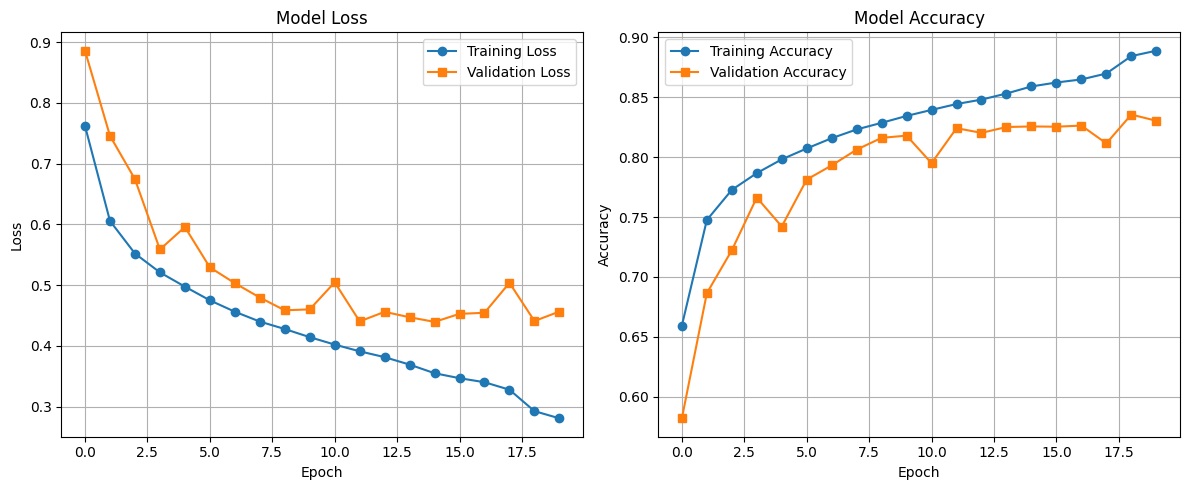

In [16]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 5. a- Evaluate the model (20 Points)

Evaluating model on validation set...
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.8215 - loss: 0.4512

Validation Loss: 0.4395
Validation Accuracy: 0.8256

Generating predictions for confusion matrix...


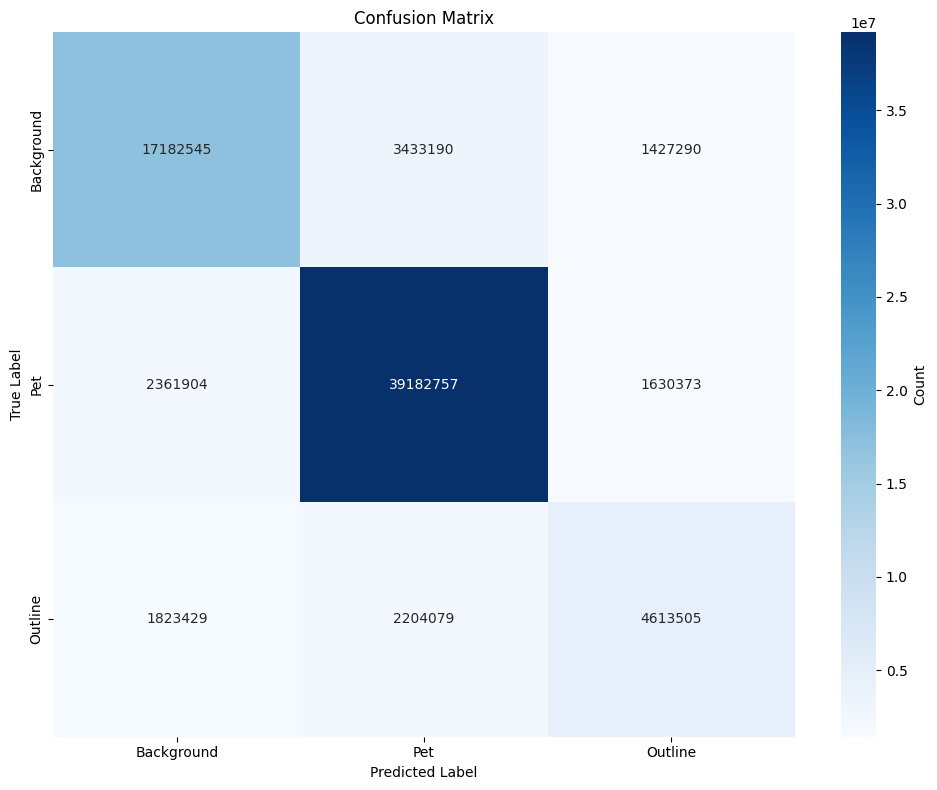


Classification Report:
              precision    recall  f1-score   support

  Background       0.80      0.78      0.79  22043025
         Pet       0.87      0.91      0.89  43175034
     Outline       0.60      0.53      0.57   8641013

    accuracy                           0.83  73859072
   macro avg       0.76      0.74      0.75  73859072
weighted avg       0.82      0.83      0.82  73859072


Per-Class Accuracy:
Background: 0.7795
Pet: 0.9075
Outline: 0.5339


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model on validation set
print("Evaluating model on validation set...")
val_loss, val_accuracy = model.evaluate(val_gen, verbose=1)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions for confusion matrix
print("\nGenerating predictions for confusion matrix...")
all_predictions = []
all_targets = []

# Process validation data in batches
for i in range(len(val_gen)):
    x_batch, y_batch = val_gen[i]
    predictions = model.predict(x_batch, verbose=0)
    # Get predicted class (argmax)
    predicted_classes = np.argmax(predictions, axis=-1)
    all_predictions.extend(predicted_classes.flatten())
    all_targets.extend(y_batch.flatten())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Create confusion matrix
cm = confusion_matrix(all_targets, all_predictions, labels=[0, 1, 2])

# Display confusion matrix
plt.figure(figsize=(10, 8))
class_names = ['Background', 'Pet', 'Outline']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(all_targets, all_predictions,
                          target_names=class_names,
                          labels=[0, 1, 2]))

# Calculate and print per-class accuracy
print("\n" + "="*60)
print("Per-Class Accuracy:")
print("="*60)
for i, class_name in enumerate(class_names):
    class_mask = all_targets == i
    if np.sum(class_mask) > 0:
        class_accuracy = np.sum((all_targets == i) & (all_predictions == i)) / np.sum(class_mask)
        print(f"{class_name}: {class_accuracy:.4f}")
    else:
        print(f"{class_name}: N/A (no samples)")


## 5.b- Visualize semantic segmentation on a few sample images (10 Points)

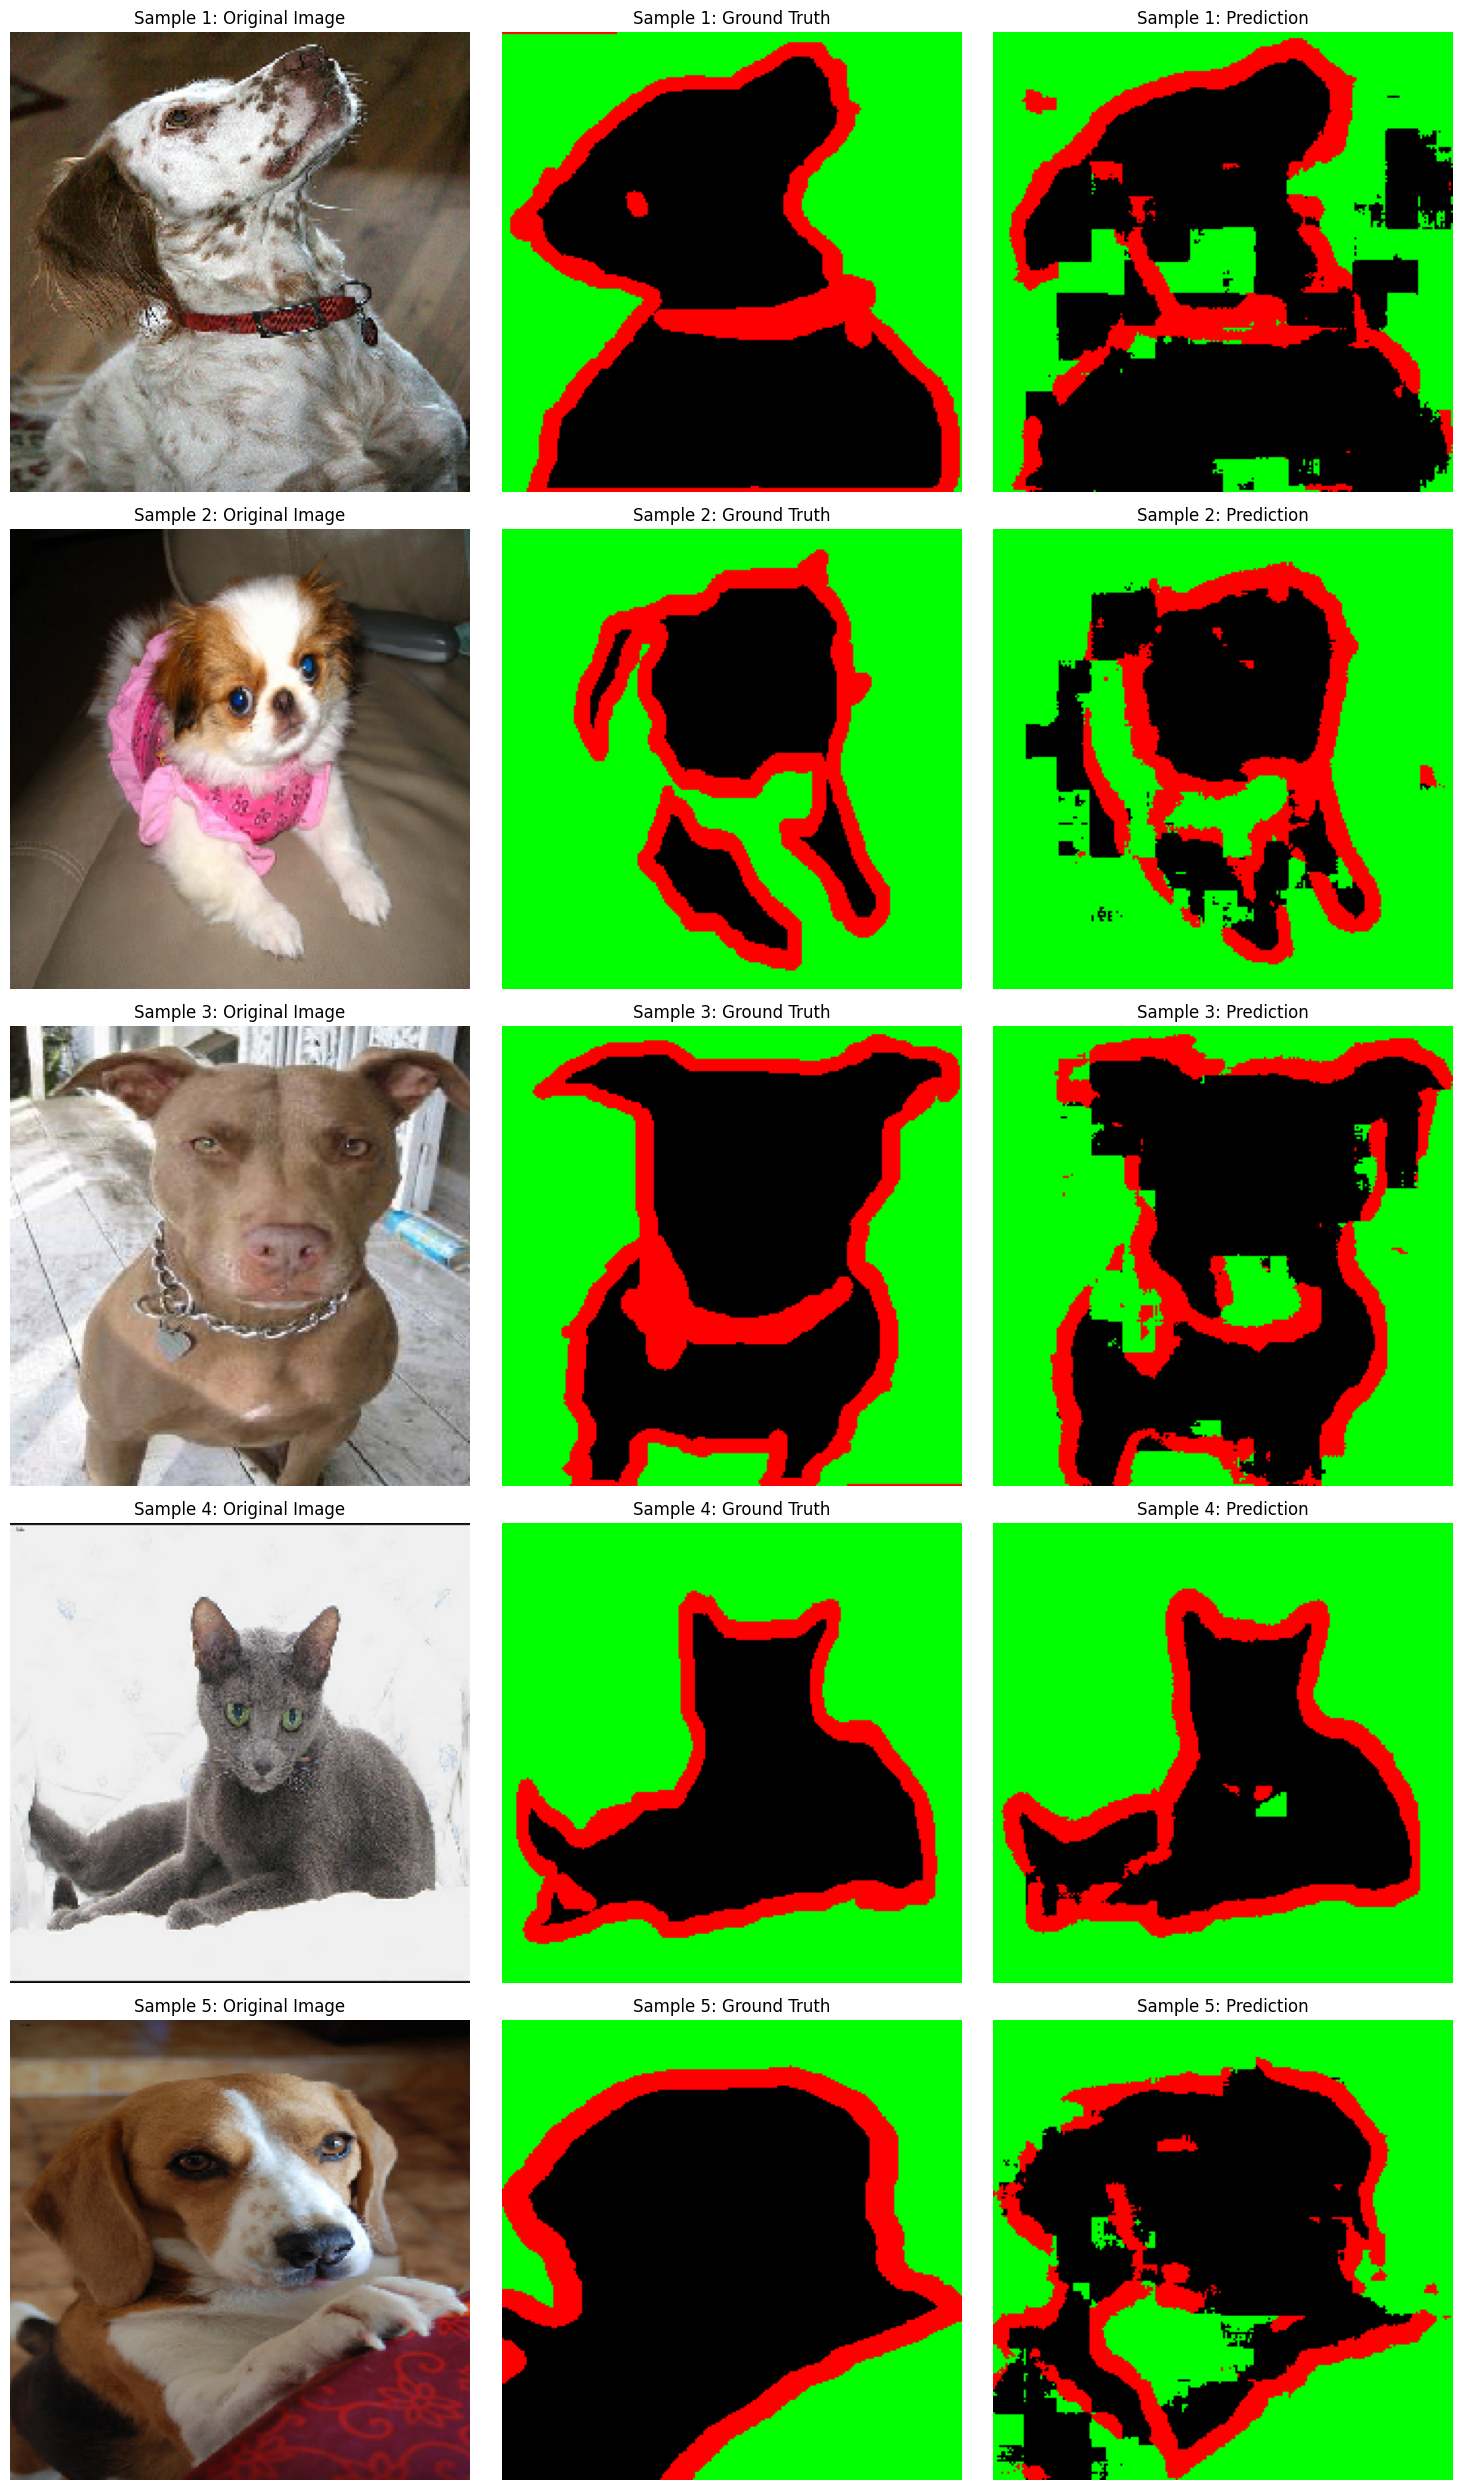

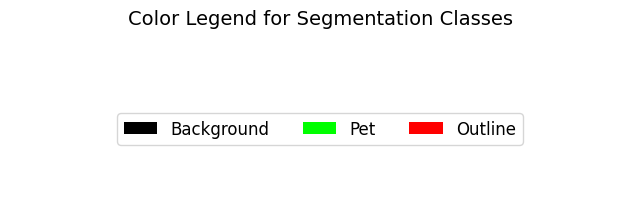

In [18]:
# Visualize semantic segmentation on sample images
import matplotlib.patches as mpatches

# Select a few sample images from validation set
num_samples = 5
sample_indices = np.random.choice(len(val_input_img_paths), num_samples, replace=False)

# Create color map for visualization
colors = np.array([
    [0, 0, 0],      # Background (black)
    [0, 255, 0],    # Pet (green)
    [255, 0, 0]     # Outline (red)
], dtype=np.uint8)

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

for idx, sample_idx in enumerate(sample_indices):
    # Load and preprocess input image
    img_path = val_input_img_paths[sample_idx]
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Get prediction
    prediction = model.predict(img_batch, verbose=0)
    predicted_mask = np.argmax(prediction[0], axis=-1)

    # Load ground truth mask
    mask_path = val_target_img_paths[sample_idx]
    gt_mask_array = img_to_array(load_img(mask_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale"))
    gt_mask_array = gt_mask_array.astype(np.float32)
    # Handle normalized values
    if gt_mask_array.max() <= 1.0:
        gt_mask_array = gt_mask_array * 255.0
    gt_mask_array = np.clip(gt_mask_array, 1, 3)
    gt_mask = (gt_mask_array[:, :, 0] - 1).astype(int)  # Convert to 0, 1, 2

    # Create colored masks for visualization
    predicted_colored = colors[predicted_mask]
    gt_colored = colors[gt_mask.astype(int)]

    # Display original image
    axes[idx, 0].imshow(img_array)
    axes[idx, 0].set_title(f'Sample {idx+1}: Original Image')
    axes[idx, 0].axis('off')

    # Display ground truth
    axes[idx, 1].imshow(gt_colored)
    axes[idx, 1].set_title(f'Sample {idx+1}: Ground Truth')
    axes[idx, 1].axis('off')

    # Display prediction
    axes[idx, 2].imshow(predicted_colored)
    axes[idx, 2].set_title(f'Sample {idx+1}: Prediction')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

# Create legend
legend_elements = [mpatches.Patch(facecolor=color/255.0, label=label)
                   for color, label in zip(colors, ['Background', 'Pet', 'Outline'])]
plt.figure(figsize=(8, 2))
plt.axis('off')
plt.legend(handles=legend_elements, loc='center', ncol=3, fontsize=12)
plt.title('Color Legend for Segmentation Classes', fontsize=14, pad=20)
plt.show()
